In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch

from proposed.inference import predict
from raw_data.kitti_dataset import KITTIDataset
from raw_data.utils import cloud2depth

DepthNet with ResNet101 and input size (172, 172) produces the following feature pyramid:
(1, 256, 43, 43)
(1, 512, 22, 22)
(1, 1024, 11, 11)
(1, 2048, 6, 6)



/home/antoniof/paper/proposed/inference.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('results', 'proposed_train', 'run_

In [2]:
data_set = KITTIDataset('test', center_crop=False)

In [3]:
idx = 102
image, camera, point_cloud = data_set[idx]

# Ground truth
depth = cloud2depth(point_cloud, camera)
valid = (depth > 0)
z = depth[valid]
y, x = np.where(valid)

# Prediction
pred_depth = predict(image, camera, use_grid_sampling=True)

/home/antoniof/paper/proposed/inference.py:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residuals, _, _ = np.linalg.lstsq(X, z) # residuals shape = (1,)
/home/antoniof/paper/proposed/inference.py:136: RuntimeWarning: invalid value encountered in divide
  res = pred.sum(axis=0) / valid.sum(axis=0)


/tmp/ipykernel_1438287/556287536.py:9: RuntimeWarning: divide by zero encountered in divide
  rel_err = np.abs(depth - pred_depth) / pred_depth
/tmp/ipykernel_1438287/556287536.py:9: RuntimeWarning: invalid value encountered in divide
  rel_err = np.abs(depth - pred_depth) / pred_depth


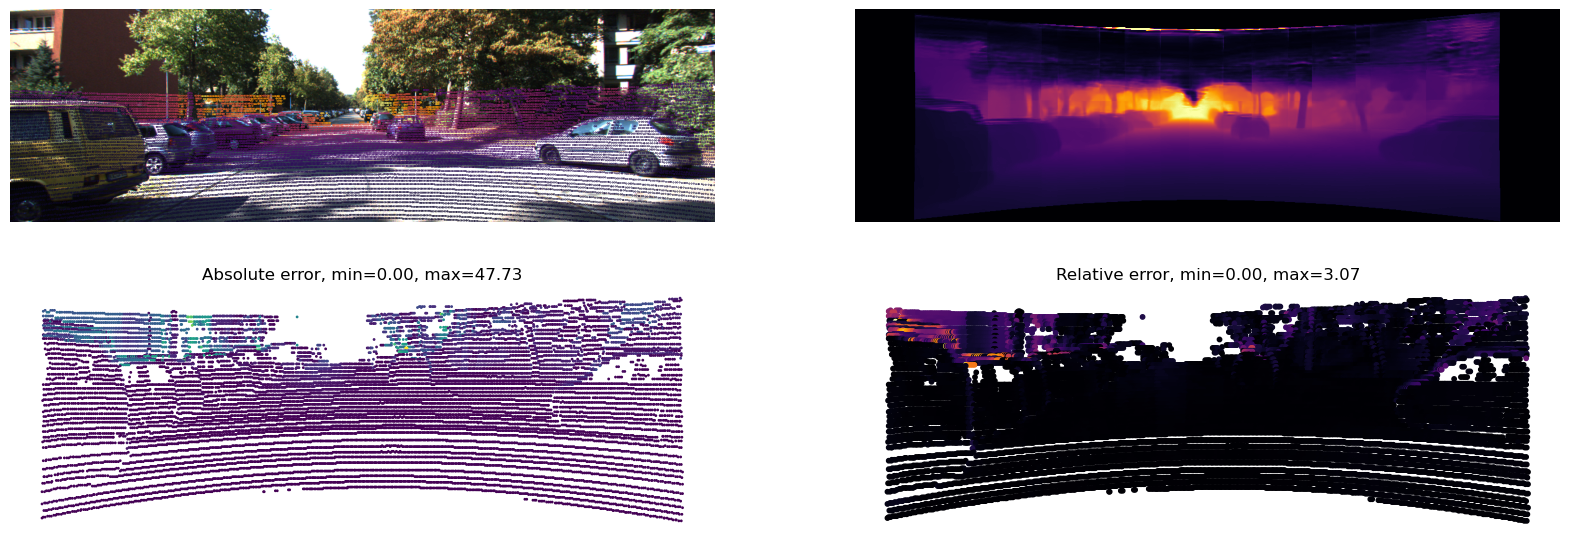

In [4]:
# Errors
abs_err = np.abs(depth - pred_depth)
abs_err[(depth == 0) | (pred_depth == 0)] = 0#np.nan

valid_abs = (abs_err > 0)
z_abs = abs_err[valid_abs]
y_abs, x_abs = np.where(valid_abs)

rel_err = np.abs(depth - pred_depth) / pred_depth
rel_err[(depth == 0) | (pred_depth == 0)] = 0

valid_rel = (rel_err > 0)
z_rel = rel_err[valid_rel]
y_rel, x_rel = np.where(valid_rel)

plt.figure(figsize=(20, 7))

plt.subplot(221)
plt.axis("off")
plt.imshow(image)
plt.scatter(x, y, c=z, cmap='inferno', s=0.1, vmin=data_set.min_depth, vmax=data_set.max_depth)

plt.subplot(222)
plt.axis("off")
plt.imshow(pred_depth,cmap='inferno', vmin=data_set.min_depth, vmax=data_set.max_depth)

plt.subplot(223)
plt.axis("off")
plt.title(f"Absolute error, min={z_abs.min():.2f}, max={z_abs.max():.2f}")
#plt.imshow(image)
plt.scatter(x_abs, -y_abs, c=z_abs, cmap='viridis', s=1)

plt.subplot(224)
plt.axis("off")
plt.title(f"Relative error, min={z_rel.min():.2f}, max={z_rel.max():.2f}")
#plt.imshow(image)
plt.scatter(x_rel, -y_rel, c=z_rel, cmap='inferno', s=10)

In [5]:
def compute_metrics(pred_depth: np.ndarray, depth: np.ndarray, min_depth: float, max_depth: float) -> dict[str, float]:
    pred_depth # shape = (H_pred, W_pred)
    depth # shape = (H_depth, W_depth)

    # Resize pred_depth to match depth size
    if pred_depth.shape != depth.shape:
        pred_depth = skimage.transform.resize(pred_depth, depth.shape, order=0)
    
    # Consider only valid pixels
    valid = (depth > 0)
    if not valid.any():
        raise ValueError("No valid pixels in the ground-truth depth map")
    
    pred_valid = (pred_depth > 0)
    if not pred_valid.any():
        raise ValueError("No valid pixels in the predicted depth map")
    
    val_percentage = ((~pred_valid) & valid).mean()
    mask = valid & pred_valid
    if not mask.any():
        raise ValueError("No valid pixels corresponding both to ground-truth and predicted depth maps")
    
    depth = depth[mask].reshape(-1) # shape = (num_valid_pixels,)
    pred_depth = pred_depth[mask].reshape(-1) # shape = (num_valid_pixels,)

    # Clamp prediction and ground truth
    depth = depth.clip(min_depth, max_depth)
    pred_depth = pred_depth.clip(min_depth, max_depth)

    # Compute accuracy metrics
    thresh = np.max(np.stack([(depth / pred_depth), (pred_depth / depth)], axis=0), axis=0)
    mask_a1 = (thresh < 1.25)
    mask_a2 = (thresh < 1.25 ** 2)
    mask_a3 = (thresh < 1.25 ** 3)
    a1 = (mask_a1.mean(dtype=np.float32).item() if mask_a1.any() else 0.)
    a2 = (mask_a2.mean(dtype=np.float32).item() if mask_a2.any() else 0.)
    a3 = (mask_a3.mean(dtype=np.float32).item() if mask_a3.any() else 0.)

    # Compute error metrics
    rmse = (depth - pred_depth) ** 2
    rmse = np.sqrt(rmse.mean()).item()

    rmse_log = (np.log(depth) - np.log(pred_depth)) ** 2
    rmse_log = np.sqrt(rmse_log.mean()).item()

    abs_rel = np.mean(np.abs(depth - pred_depth) / depth).item()

    sq_rel = np.mean(((depth - pred_depth) ** 2) / depth).item()

    d = np.log(depth) - np.log(pred_depth)
    si_err = (np.mean(d**2) - np.mean(d)**2).item()

    return {
        'val_percentage': val_percentage,
        'a1': a1,
        'a2': a2,
        'a3': a3,
        'abs_rel': abs_rel,
        'sq_rel': sq_rel,
        'rmse': rmse,
        'rmse_log': rmse_log,
        'si_err': si_err,
    }

In [6]:
compute_metrics(pred_depth[:, 300:], depth[:, 300:], data_set.min_depth, data_set.max_depth)

{'val_percentage': 0.007450813871196037,
 'a1': 0.9291344881057739,
 'a2': 0.9829860329627991,
 'a3': 0.9962537884712219,
 'abs_rel': 0.06443384854462797,
 'sq_rel': 0.435071694084484,
 'rmse': 4.31841784125117,
 'rmse_log': 0.1241178868807619,
 'si_err': 0.015213035148807251}